Predicting Graduate Admission Rates
------------------------------
This is my work after learning data science throughout the last couple weeks. This is also my first time writing in Python. If you see problems with my code (as in any unconventional syntax or methods) or if you could help me explore ways to achieve a better fit please leave a comment and I'll try to implement it! I would not recommend using this as a guide, but if it helps you in any way...cool!

#### Importing libraries ####

In [201]:
import pandas as pd
import seaborn as sns
import numpy as np
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score
from matplotlib import pyplot as plt

#### Loading Data ####

In [202]:
filepath = '~/Desktop/Programming/dataScience/graduate-admissions/input/Admission_Predict.csv'
df = pd.read_csv(filepath)
df.columns

Index(['Serial No.', 'GRE Score', 'TOEFL Score', 'University Rating', 'SOP',
       'LOR ', 'CGPA', 'Research', 'Chance of Admit '],
      dtype='object')


#### 'Chance of Admit ' and 'LOR 'has an extra space so we will remove it ####

In [203]:
df.rename(columns = {'Chance of Admit ': 'Chance of Admit', 'LOR ': 'LOR'}, inplace = True)
df.columns

Index(['Serial No.', 'GRE Score', 'TOEFL Score', 'University Rating', 'SOP',
       'LOR', 'CGPA', 'Research', 'Chance of Admit'],
      dtype='object')

## Understanding Data ##
Using Seaborn and Matplotlib to plot correlations to understand which variables are relevant visually

#### Correlation Plot using Seaborn ####

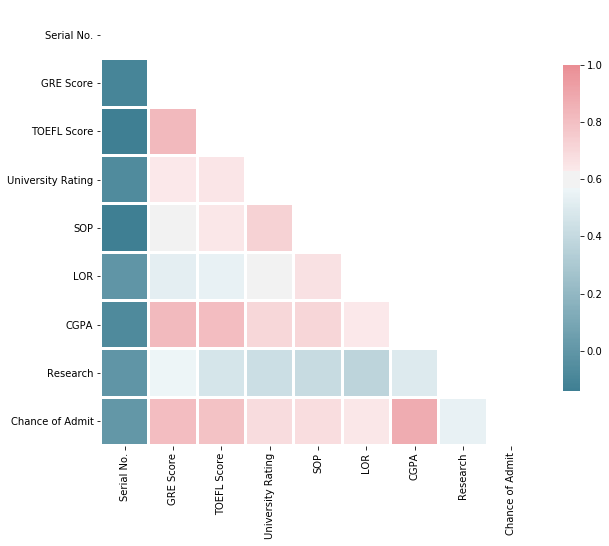

In [204]:
corr = df.corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

f, ax = plt.subplots(figsize=(10, 8))

cmap = sns.diverging_palette(220, 10, as_cmap=True)

sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, center= .6,
            square=True, linewidths=2, cbar_kws={"shrink": .75})
plt.savefig(fname = 'corr graph', dpi = 400)
plt.show()

### Understanding Data with Matplotlib and Scipy Stats ###
Used scipy.stats to calculate various correlation coeffecients based on whether data type within column is a number or object. If it is an object it creates a box plot and determines correlation with different math. Then the function outputs a list of all statistically relevant columns.

*NOTE*: I wrote this function in a previous program and reused it in this one. There aren't any object only columns.

Serial No. compared to Chance of Admit
The pcoef is: 0.008505049361131986
The p_value is: 0.8495394233354711
.....NOT ADDED.....

GRE Score compared to Chance of Admit
The pcoef is: 0.8103506354632597
The p_value is: 1.0884036862481872e-117


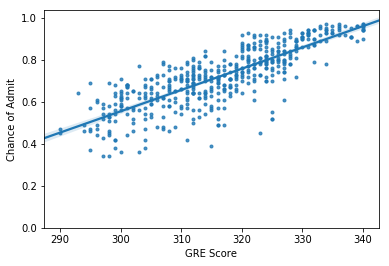

.......ADDED.......

TOEFL Score compared to Chance of Admit
The pcoef is: 0.792227614305083
The p_value is: 6.729926762330248e-109


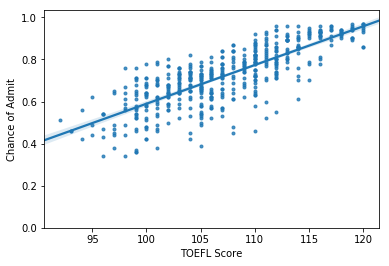

.......ADDED.......

University Rating compared to Chance of Admit
The pcoef is: 0.6901323687886891
The p_value is: 5.866255627651529e-72


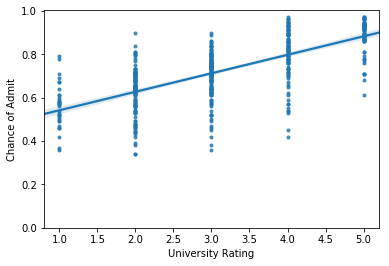

.......ADDED.......

SOP compared to Chance of Admit
The pcoef is: 0.6841365241316723
The p_value is: 2.885907453455185e-70


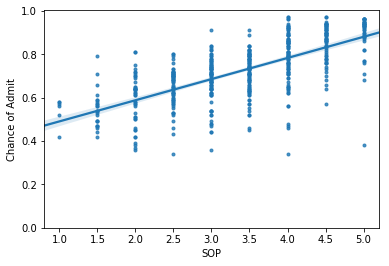

.......ADDED.......

LOR compared to Chance of Admit
The pcoef is: 0.6453645135280106
The p_value is: 3.069932320300371e-60


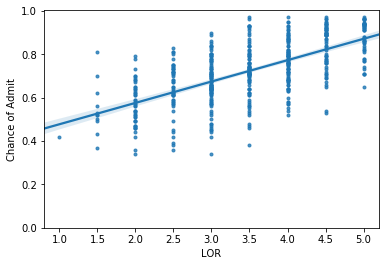

.......ADDED.......

CGPA compared to Chance of Admit
The pcoef is: 0.8824125749045744
The p_value is: 3.396544858711005e-165


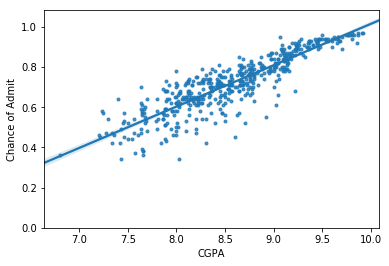

.......ADDED.......

Research compared to Chance of Admit
The pcoef is: 0.5458710294711377
The p_value is: 3.5954935458406797e-40


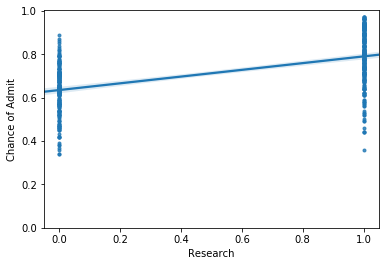

.......ADDED.......

Valuable: ['GRE Score', 'TOEFL Score', 'University Rating', 'SOP', 'LOR', 'CGPA', 'Research']


In [205]:
def isValuable(df, compareTo, plim, pcoefLim):
    """
    Determines whether certain elements of inputed DataFrame are statistically relevant to the 'comparedto' column
    df = DataFrame
    compareTo = column to compare
    plim = limit on p value to be considered relevant
    pcoefLim = limit on pcoef value to be considered relevant
    """
    dictDf = df.to_dict('series')
    effectors = []
    for column in df:
        if (df[column].dtype != 'object'):
            if not (df[column].equals(df[compareTo])):
                pcoef, p = stats.pearsonr(df[compareTo], df[column])
                print("{} compared to {}".format(column, compareTo))
                print(("The pcoef is: {}\nThe p_value is: {}").format(pcoef, p))
                if (pcoef > pcoefLim) or (pcoef < -pcoefLim) and (p < plim):
                    effectors.append(column)
                    sns.regplot(x = df[column], y = df[compareTo], data=df, marker = '.')
                    plt.ylim(0,)
                    plt.show()
                    print(".......ADDED.......")
                else:
                    print(".....NOT ADDED.....")
                print("")
        else:
            columnName = df[column].name
            grouped = df[[columnName, compareTo]].groupby(columnName)
            uniqueElements = dictDf[column].unique()
            elements = []
            for thing in uniqueElements:
                try:
                    specialGroup = grouped.get_group(thing)[compareTo]
                    elements.append(specialGroup)
                except:
                    pass
            f, p = stats.f_oneway(*elements)
            print(("After ANOVA Analysis of {} compared to {}:\nF Value: {}\nP Value: {}").format(columnName, compareTo, f, p))
            if (p < plim):
                effectors.append(column)
                sns.boxplot(x= df[column], y=df[compareTo], data=df)
                plt.show()
                print(".......ADDED.......")
            print("")
    return effectors
effectors = isValuable(df, 'Chance of Admit', .01, .5)
print('Valuable:', effectors)


### Fiting Model with LinearRegression and with a PolyFeatures Pipeline ###
Ended up with not to bad R^2, but I was still skeptical whether this actually is true. So I did a train_test_split to verify correlation. Previously had my PolynomialFeatures model with a higher R^2 but after further investigation (train_test_split) I was overfitting the data, hence the poor R^2 with split data.


In [206]:
X = df[effectors]
y = df['Chance of Admit']

In [207]:
XTrain, XTest, yTrain, yTest = train_test_split(X, y, test_size = .3, random_state = 1)
MLR = LinearRegression()
MLR.fit(XTrain, yTrain)
r2 = MLR.score(XTest, yTest)
print(("Split R^2 Score: {:.5}").format(r2))
MLR.fit(X, y)
r2 = MLR.score(X, y)
print(("Full R^2 Score:  {:.5}").format(r2))

Split R^2 Score: 0.81577
Full R^2 Score:  0.8219


In [210]:
#to avoid data conversion warnings
X = X.astype('float64')
XTrain, XTest, yTrain, yTest = train_test_split(X, y, test_size = .3, random_state = 1)
#creating pipeline
Input=[('scale',StandardScaler()), ('polynomial', PolynomialFeatures(degree=3)), ('model',LinearRegression())]
pipe = Pipeline(Input)
pipe.fit(XTrain, yTrain)
yhat = pipe.predict(XTest)
#getting R^2
r2_p = r2_score(yTest, yhat)
print("R^2 Score: ", r2_p)

R^2 Score:  0.6961707396553891


In [209]:
# "Perfect student"
input = [[340, 120, 1, 5, 5, 10, 1]]
#          1    2   3  4  5  6   7
# 1 - 'GRE Score' out of 340 
# 2 - 'TOEFL Score' out of 120
# 3 - 'University Rating' out of 5 (1 is top 20%, 5 bottom 20%)
# 4 - 'SOP' - Statement of Purpose strength out of 10
# 5 - 'LOR' - Letter of Rec strength out of 10
# 6 - 'CGPA'- Cumulative GPA out of 10
# 7 - 'Research' - research or no research 0 or 1
prediction = MLR.predict(input)
print("The odds that you get into a no. {} ranked school is: {:.3%}".format(input[0][2], prediction[0]))

The odds that you get into a no. 1 ranked school is: 99.585%


### Ending Note ##
What would you change about my code to make it more accurate/better? I am trying to improve both my code and the way I think about wrangling data. This community has been really fun to learn from and interact with so far, thank you for any feedback.